### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from __future__ import division
%matplotlib inline
from IPython.display import display
from sklearn.cluster import KMeans

### Get 100 most representative names for each region

In [16]:
# get our initial data
immig = pd.read_csv('Datasets/ImmigrationByRegion.csv').transpose()
immig_regions = immig.iloc[0]
immig = immig[1:]
immig = immig.rename(columns = immig_regions)
immig = immig[::-1]
display(immig)

,Europe,Asia,Africa,Oceania,Americas,Total
1850,"2,031,867","1,135",551,588,"168,484","2,244,602"
1860,"3,807,062","36,796",526,"2,140","288,285","4,138,697"
1870,"4,941,049","64,565","2,657","4,028","551,338","5,567,229"
1880,"5,751,823","107,630","2,204","6,859","807,359","6,679,943"
1890,"8,030,347","113,383","2,207","9,353","1,088,245","9,249,547"
1900,"8,881,548","120,248","2,538","8,820","1,317,380","10,341,276"
1910,"11,810,115","191,484","3,992","11,450","1,489,231","13,515,886"
1920,"11,916,048","237,950","16,126","14,626","1,727,017","13,920,692"
1950,"11,784,010","275,665","18,326","17,343","2,102,209","14,204,149"
1960,"7,256,311","490,996","35,355","34,730","1,860,809","9,738,091"


In [17]:
# then clean our names
names = pd.read_csv('Datasets/NationalNames.csv', delimiter = ',', usecols = [1, 2, 3, 4])
names = names.groupby(['Name', 'Year'])['Count'].sum()
names = names.unstack(level=0)
display(names.head())

Name,Aaban,Aabha,Aabid,Aabriella,Aadam,Aadan,Aadarsh,Aaden,Aadesh,Aadhav,...,Zyshon,Zyshonne,Zytaevius,Zytaveon,Zytavion,Zytavious,Zyvion,Zyyanna,Zyyon,Zzyzx
Year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# now groupby 10 and at last we have what we want
names_10 = names.groupby([(y / 10) * 10 for y in names.index.values]).sum().fillna(0)
display(names_10)

Name,Aaban,Aabha,Aabid,Aabriella,Aadam,Aadan,Aadarsh,Aaden,Aadesh,Aadhav,...,Zyshon,Zyshonne,Zytaevius,Zytaveon,Zytavion,Zytavious,Zyvion,Zyyanna,Zyyon,Zzyzx
1880.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1881.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1883.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1885.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1886.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1887.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1888.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1889.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# get some useful tools out of the way now
# to check for empty values in immigration
import re
numeric = re.compile("\d+(?:,\d+)?")
# display(s[s.str.match("\d+(?:,\d+)?")])
# to normalize series
def normalize(series):
    max_val = series.max()
    min_val = series.min()
    return (series - min_val) / (max_val - min_val)
def standardize(series):
    return (series - series.mean()) / series.std()

In [20]:
region_dict = {}
# short circuit example:
# for region in immig.columns[:5]:
for region in immig.columns:
    # this takes a while, so just to track progress--
    print 'Calculating ', region, ' :',
    region_vals = immig[region].fillna('(NA)')
    # filter for only immigration years with present values
    #region_vals = region_vals[region_vals.str.match("\d+(?:,\d+)?")]
    # find the years both names and immigration have
    # handle string nature of immigration years
    common_years = names_10.index.intersection(region_vals.index.map(int))
    # filter immigration years by common years, handling int/str switch
    region_vals = region_vals[map(str, common_years)]
    # then map back to int, handling commas
    region_vals = region_vals.apply(lambda x: int(x.replace(',', '')))
    # and normalize
    region_vals = normalize(region_vals)
    region_dict[region] = []
    name_num = 0
    # short circuit example:
    # for name in names_10.columns[:10000]:
    for name in names_10.columns:
        # more progress tracking
        if name_num % 5000 == 0:
            print name, '...',
        name_vals = names_10[name]
        name_vals = name_vals[common_years]
        name_vals = normalize(name_vals)
        # handle some empty arrays because 2010 exclusion
        if name_vals.isnull().any():
            score = -10
        else:
            # first value is true--actual immigration data
            # second value is predict--name data we're trying to use as model
            score = r2_score(region_vals, name_vals)
        region_dict[region].append((name, score))
        name_num += 1
    print 'done!' 

Calculating  Europe  : Aaban ... Analysia ... Barnard ... Cesear ... Daralyn ... Dvir ... Gabryelle ... Isbel ... Jeraldo ... Kaston ... Kynsleigh ... Luceli ... Meera ... Nicholaos ... Raimee ... Saraelizabeth ... Solangel ... Tiffiani ... Willabell ... done!
Calculating  Asia  : Aaban ... Analysia ... Barnard ... Cesear ... Daralyn ... Dvir ... Gabryelle ... Isbel ... Jeraldo ... Kaston ... Kynsleigh ... Luceli ... Meera ... Nicholaos ... Raimee ... Saraelizabeth ... Solangel ... Tiffiani ... Willabell ... done!
Calculating  Africa  : Aaban ... Analysia ... Barnard ... Cesear ... Daralyn ... Dvir ... Gabryelle ... Isbel ... Jeraldo ... Kaston ... Kynsleigh ... Luceli ... Meera ... Nicholaos ... Raimee ... Saraelizabeth ... Solangel ... Tiffiani ... Willabell ... done!
Calculating  Oceania  : Aaban ... Analysia ... Barnard ... Cesear ... Daralyn ... Dvir ... Gabryelle ... Isbel ... Jeraldo ... Kaston ... Kynsleigh ... Luceli ... Meera ... Nicholaos ... Raimee ... Saraelizabeth ... Sol

In [21]:
for region in region_dict:
    name_scores = region_dict[region]
    name_scores = sorted(name_scores, key=lambda x: -x[1])
    name_scores = [(x[0], round(x[1], 2)) for x in name_scores]
    region_dict[region] = name_scores
    print region, ': ', name_scores[:100]

Europe :  [('Clyda', 0.92), ('Rosia', 0.91), ('Evelena', 0.9), ('Vannie', 0.83), ('Ottie', 0.82), ('Louella', 0.82), ('Lona', 0.81), ('Pearlie', 0.81), ('Roxie', 0.81), ('Tempie', 0.8), ('Vallie', 0.8), ('Pleas', 0.8), ('Leonia', 0.8), ('Clemmie', 0.8), ('Otelia', 0.8), ('Artie', 0.78), ('Lesta', 0.78), ('Wilhelmina', 0.78), ('Mose', 0.77), ('Hamp', 0.77), ('Estella', 0.75), ('Jannie', 0.75), ('Florida', 0.75), ('Hosey', 0.74), ('Dollie', 0.74), ('Parthenia', 0.74), ('Fleming', 0.74), ('Classie', 0.73), ('Sallie', 0.73), ('Lucetta', 0.72), ('Lethia', 0.72), ('Lauretta', 0.72), ('Ceil', 0.71), ('Hetty', 0.71), ('Electa', 0.71), ('Luvenia', 0.71), ('Susie', 0.7), ('Pinkie', 0.7), ('Mammie', 0.7), ('Lawyer', 0.7), ('Zona', 0.69), ('Leatha', 0.69), ('Della', 0.68), ('Luberta', 0.68), ('Booker', 0.68), ('Birtha', 0.67), ('Rosie', 0.67), ('Louetta', 0.67), ('Louvenia', 0.67), ('Clydie', 0.66), ('Collie', 0.66), ('Berta', 0.66), ('Fleeta', 0.66), ('Early', 0.66), ('Jinnie', 0.66), ('Moody', 0

### Save names in csv files
You can skip this section since these individual files were later compiled into a single file: "represnames.csv".

In [ ]:
scores_Total = region_dict['Total'][:100]
names_Total = []
for i in range(100):
    name = scores_Total[i][0]
    names_Total.append(name)

Total_csv = pd.DataFrame({'Names': names_Total})
Total_csv.to_csv('names_Total.csv', sep=',', columns = ['Names'], header = ['Names'],
                         index = False)

In [ ]:
scores_Europe = region_dict['Europe'][:100]
names_Europe = []
for i in range(100):
    name = scores_Europe[i][0]
    names_Europe.append(name)

Europe_csv = pd.DataFrame({'Names': names_Europe})
Europe_csv.to_csv('names_Europe.csv', sep=',', columns = ['Names'], header = ['Names'],
                         index = False)

In [ ]:
scores_Oceania = region_dict['Oceania'][:100]
names_Oceania = []
for i in range(100):
    name = scores_Oceania[i][0]
    names_Oceania.append(name)

Oceania_csv = pd.DataFrame({'Names': names_Oceania})
Oceania_csv.to_csv('names_Oceania.csv', sep=',', columns = ['Names'], header = ['Names'],
                         index = False)

In [ ]:
scores_Africa = region_dict['Africa'][:100]
names_Africa = []
for i in range(100):
    name = scores_Africa[i][0]
    names_Africa.append(name)

Africa_csv = pd.DataFrame({'Names': names_Africa})
Africa_csv.to_csv('names_Africa.csv', sep=',', columns = ['Names'], header = ['Names'],
                         index = False)

In [ ]:
scores_Asia = region_dict['Asia'][:100]
names_Asia = []
for i in range(100):
    name = scores_Asia[i][0]
    names_Asia.append(name)

Asia_csv = pd.DataFrame({'Names': names_Asia})
Asia_csv.to_csv('names_Asia.csv', sep=',', columns = ['Names'], header = ['Names'],
                         index = False)

In [ ]:
scores_Americas = region_dict['Americas'][:100]
names_Americas = []
for i in range(100):
    name = scores_Americas[i][0]
    names_Americas.append(name)

Americas_csv = pd.DataFrame({'Names': names_Americas})
Americas_csv.to_csv('names_Americas.csv', sep=',', columns = ['Names'], header = ['Names'],
                         index = False)

### Most representative names by state

In [22]:
# get our state names again
state_names = pd.read_csv('Datasets/StateNames.csv', delimiter = ',', usecols = [1, 2, 3, 4, 5])
# slow, but less annoying than typing in manually...
state_list = np.unique(state_names['State'].values)

In [23]:
# get our most representative names
region_names = pd.read_csv('Datasets/repres_names/repres_names.csv', delimiter = ',')
display(region_names.head())

,Africa,Americas,Asia,Europe,Oceania,Total
0,Charlee,Grey,Sura,Roxie,Sloan,Mckinley
1,Raelyn,Nikolai,Ariella,Leeta,Weston,Milan
2,Emberly,Sura,Yerachmiel,Lona,Solange,Mccoy
3,Kathalina,Remi,Elif,Susie,Boone,Adelina
4,Jader,Jenson,Adrielle,Eugenie,Kiyomi,Evalina


In [24]:
# requires a state_list and region_names global
def cross_best_names(region, year, byDecade=False):
    # build a dictionary of counts by state and then name
    # count by decade as an option
    years = range(year, year + 11 if byDecade else year + 1)
    state_names_by_year = state_names[state_names['Year'].isin(years)]
    names_dict = {}
    names = state_names_by_year.iloc[:,0].values
    counts = state_names_by_year.iloc[:,-1].values
    states = state_names_by_year.iloc[:,-2].values
    for i in range(len(state_names_by_year.index)):
        if states[i] not in names_dict:
            names_dict[states[i]] = {}
        if names[i] not in names_dict[states[i]]:
            names_dict[states[i]][names[i]] = counts[i]
        else:
            names_dict[states[i]][names[i]] += counts[i]
    # build our matrix of names by states
    df = pd.DataFrame(index=state_list)
    for n in region_names[region]:
        state_name_counts = []
        for s in state_list:
            if s in names_dict and n in names_dict[s]:
                state_name_counts.append(names_dict[s][n])
            else:
                state_name_counts.append(0)    
        df[n] = pd.Series(state_name_counts, index=state_list)
    return df

### PCA Visual Analysis

In [25]:
regions = pd.read_csv('Datasets/regions.csv', delimiter = ',', usecols = [2], header=None)

In [26]:
#Function to plot first two principal components
def pca_per_decaderegion(region, decade, ax):
    x = cross_best_names(region, decade, byDecade=True)
    df_norm = (x-x.mean())/x.std()
    df_norm = df_norm.fillna(0)
    #Apply PCA to data and get the top 2 axes of maximum variation
    pca = PCA(n_components=2)
    pca.fit(df_norm.values)

    #Project to the data onto the two axes
    x_reduced = pca.transform(df_norm.values)
    
    region_x = pd.DataFrame(x_reduced, columns=['PC-1', 'PC-2'])
    us_region = region_x.join(regions)
    
    #print x_reduced
    #Visualized our reduced data
    #region.ix[region['region']== 'South', 1]
    ax.scatter(us_region.ix[us_region.iloc[:,2] == 'South', 0], us_region.ix[us_region.iloc[:,2] == 'South', 1], 
           color='b', label = 'South')
    ax.scatter(us_region.ix[us_region.iloc[:,2] == 'West', 0], us_region.ix[us_region.iloc[:,2] == 'West', 1], 
           color='g', label = 'West')
    ax.scatter(us_region.ix[us_region.iloc[:,2] == 'Midwest', 0], us_region.ix[us_region.iloc[:,2] == 'Midwest', 1], 
           color='r', label = 'Midwest')
    ax.scatter(us_region.ix[us_region.iloc[:,2] == 'Northeast', 0], us_region.ix[us_region.iloc[:,2] == 'Northeast', 1], 
           color='y', label = 'Northeast')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(str(region) + str(decade)+'data projected onto the first 2 PCA components')
    ax.legend()
    
    return ax

### Europe

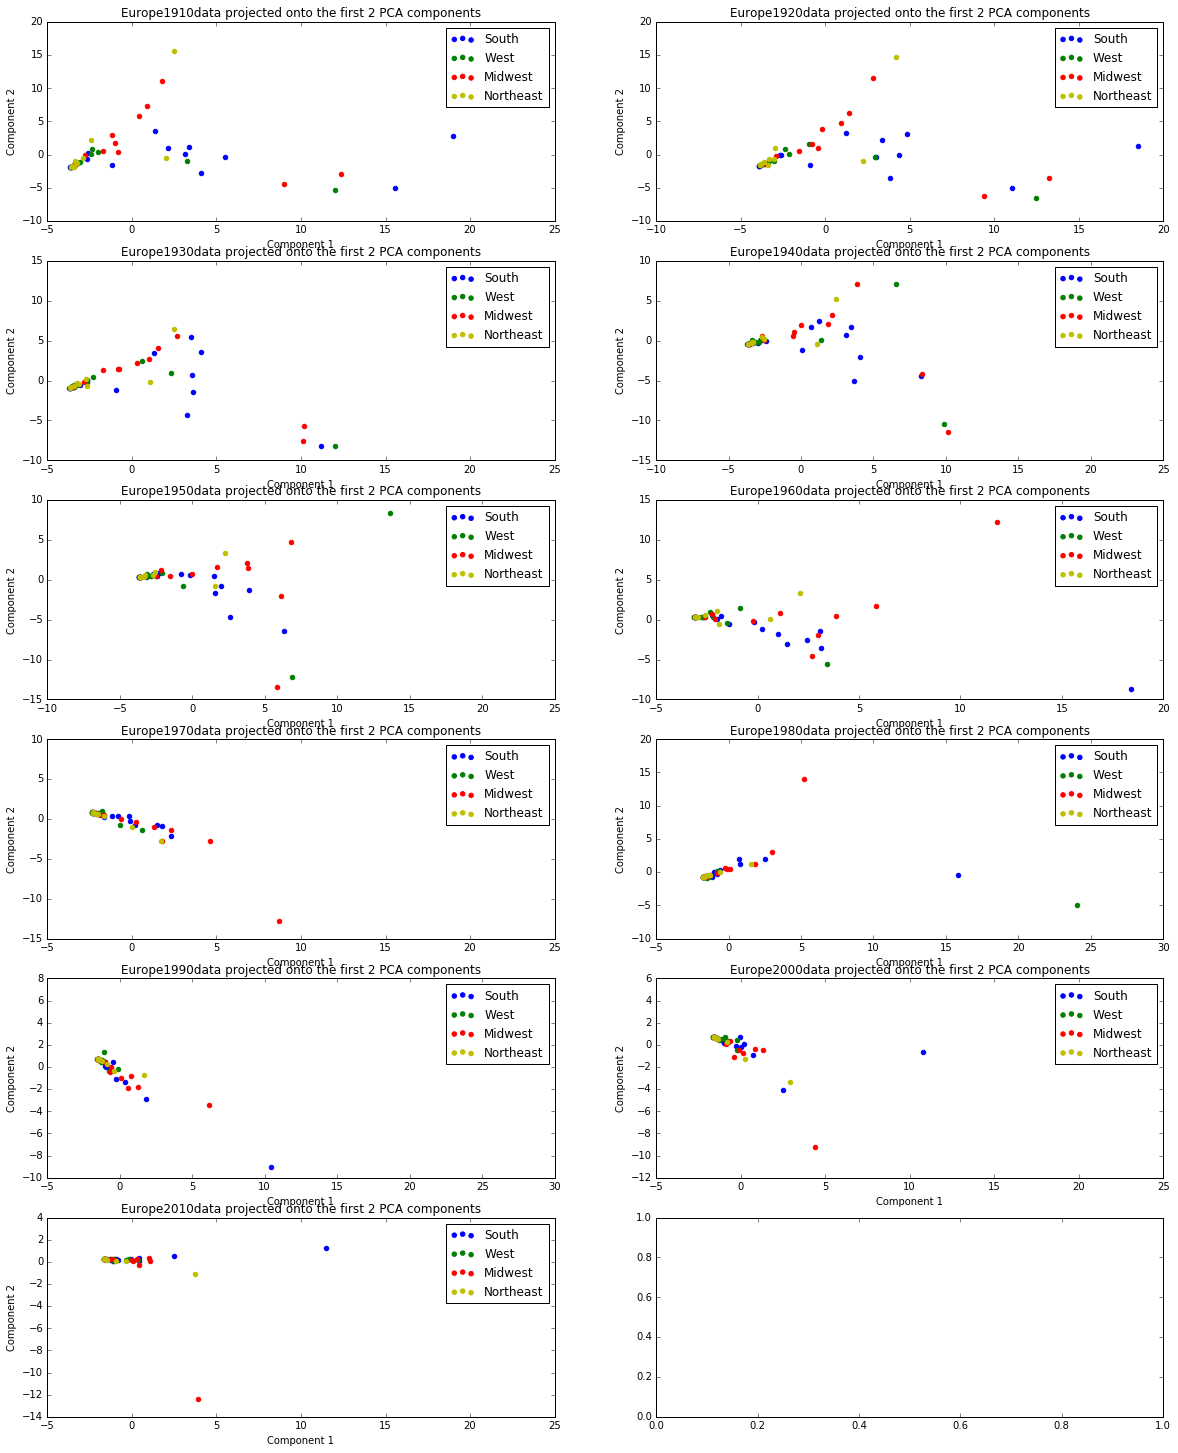

In [73]:
#plotting first two principal components for Europe per decade
fig, ax = plt.subplots(6, 2, figsize = (20,25))
ax[0,0] = pca_per_decaderegion('Europe',1910, ax[0,0])
ax[0,1] = pca_per_decaderegion('Europe',1920, ax[0,1])
ax[1,0] = pca_per_decaderegion('Europe',1930, ax[1,0])
ax[1,1] = pca_per_decaderegion('Europe',1940, ax[1,1])
ax[2,0] = pca_per_decaderegion('Europe',1950, ax[2,0])
ax[2,1] = pca_per_decaderegion('Europe',1960, ax[2,1])
ax[3,0] = pca_per_decaderegion('Europe',1970, ax[3,0])
ax[3,1] = pca_per_decaderegion('Europe',1980, ax[3,1])
ax[4,0] = pca_per_decaderegion('Europe',1990, ax[4,0])
ax[4,1] = pca_per_decaderegion('Europe',2000, ax[4,1])
ax[5,0] = pca_per_decaderegion('Europe',2010, ax[5,0])

#plt.tight_layout()
plt.show()

In [74]:
fig.savefig('pca_europe.png', bbox_inches='tight')

### Africa

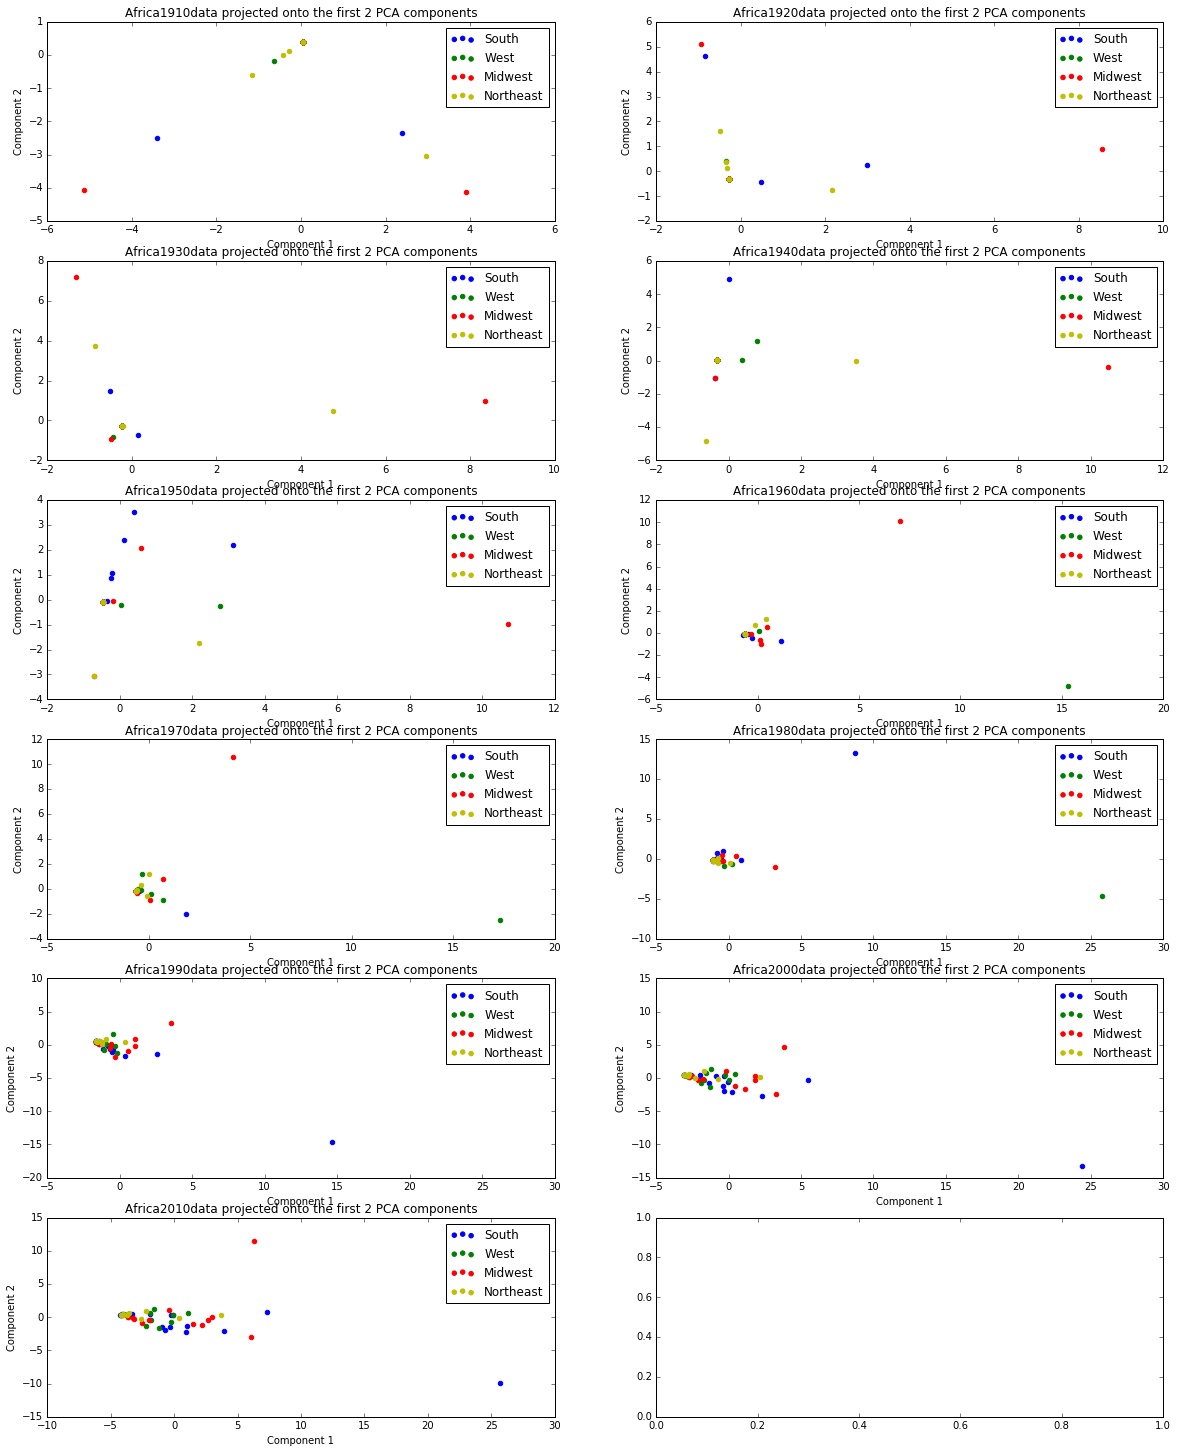

In [31]:
#plotting first two principal components for Africa per decade
fig, ax = plt.subplots(6, 2, figsize = (20,25))
ax[0,0] = pca_per_decaderegion('Africa',1910, ax[0,0])
ax[0,1] = pca_per_decaderegion('Africa',1920, ax[0,1])
ax[1,0] = pca_per_decaderegion('Africa',1930, ax[1,0])
ax[1,1] = pca_per_decaderegion('Africa',1940, ax[1,1])
ax[2,0] = pca_per_decaderegion('Africa',1950, ax[2,0])
ax[2,1] = pca_per_decaderegion('Africa',1960, ax[2,1])
ax[3,0] = pca_per_decaderegion('Africa',1970, ax[3,0])
ax[3,1] = pca_per_decaderegion('Africa',1980, ax[3,1])
ax[4,0] = pca_per_decaderegion('Africa',1990, ax[4,0])
ax[4,1] = pca_per_decaderegion('Africa',2000, ax[4,1])
ax[5,0] = pca_per_decaderegion('Africa',2010, ax[5,0])

#plt.tight_layout()
plt.show()

In [33]:
fig.savefig('pca_africa.png', bbox_inches='tight')

### Asia

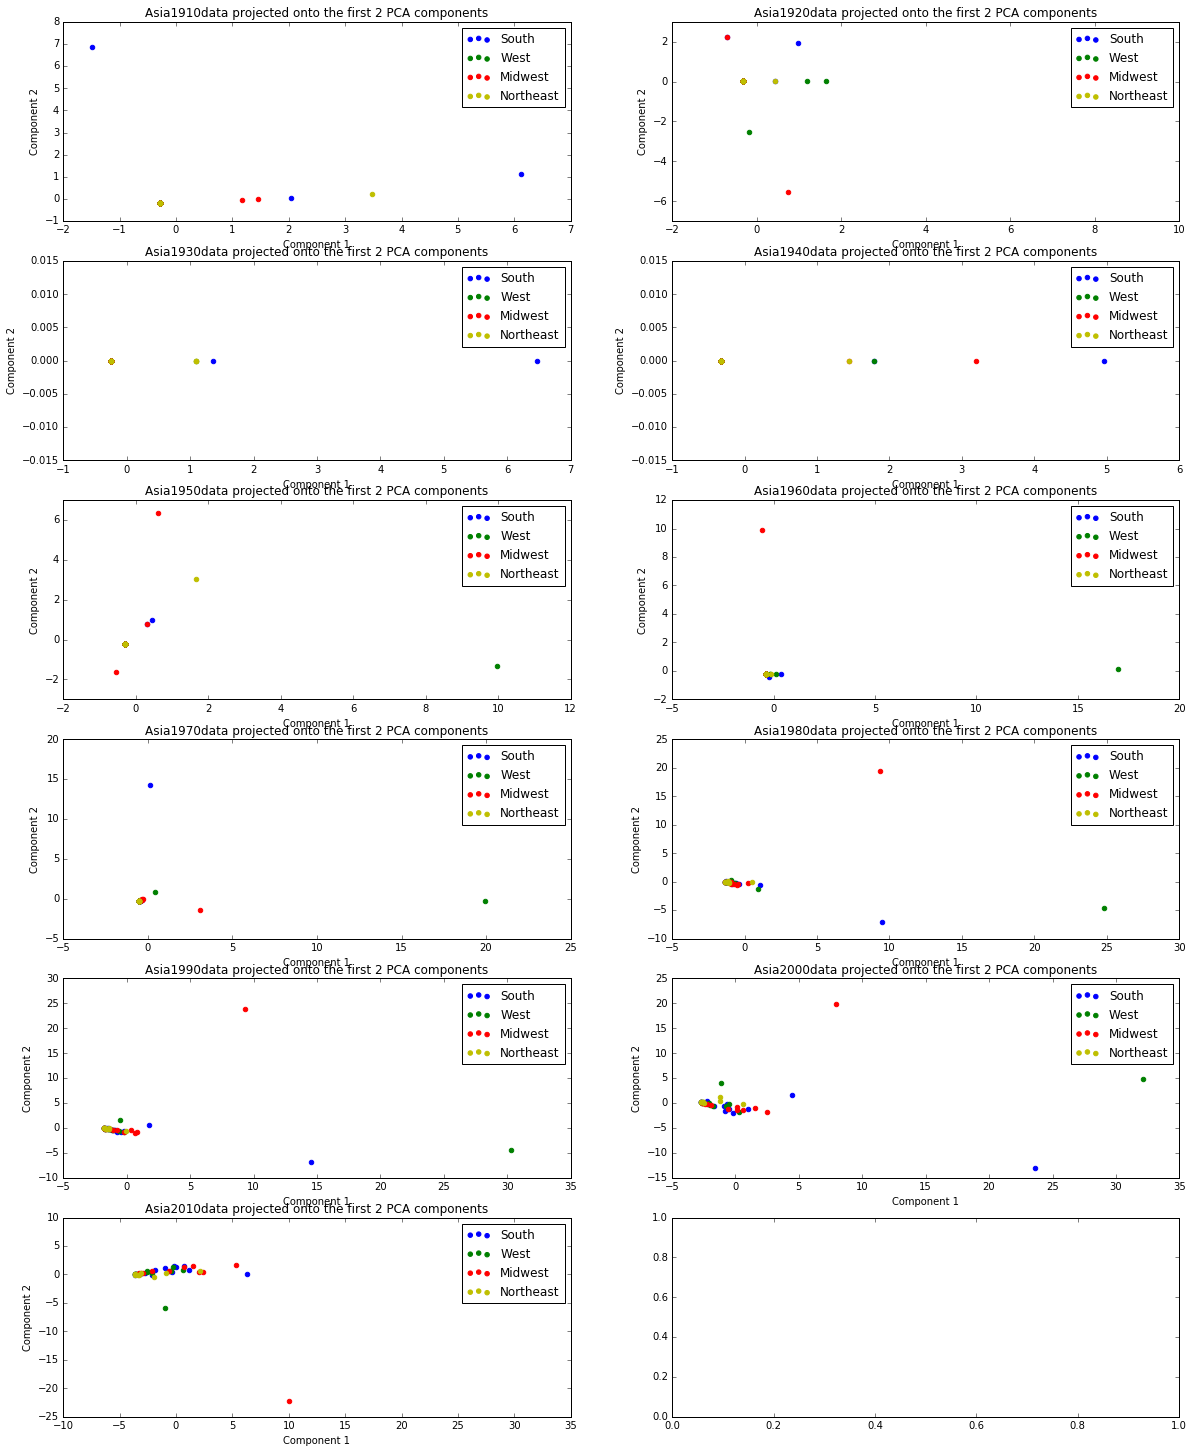

In [34]:
#plotting first two principal components for Africa per decade
fig, ax = plt.subplots(6, 2, figsize = (20,25))
ax[0,0] = pca_per_decaderegion('Asia',1910, ax[0,0])
ax[0,1] = pca_per_decaderegion('Asia',1920, ax[0,1])
ax[1,0] = pca_per_decaderegion('Asia',1930, ax[1,0])
ax[1,1] = pca_per_decaderegion('Asia',1940, ax[1,1])
ax[2,0] = pca_per_decaderegion('Asia',1950, ax[2,0])
ax[2,1] = pca_per_decaderegion('Asia',1960, ax[2,1])
ax[3,0] = pca_per_decaderegion('Asia',1970, ax[3,0])
ax[3,1] = pca_per_decaderegion('Asia',1980, ax[3,1])
ax[4,0] = pca_per_decaderegion('Asia',1990, ax[4,0])
ax[4,1] = pca_per_decaderegion('Asia',2000, ax[4,1])
ax[5,0] = pca_per_decaderegion('Asia',2010, ax[5,0])

#plt.tight_layout()
plt.show()

In [35]:
fig.savefig('pca_asia.png', bbox_inches='tight')

### Oceania

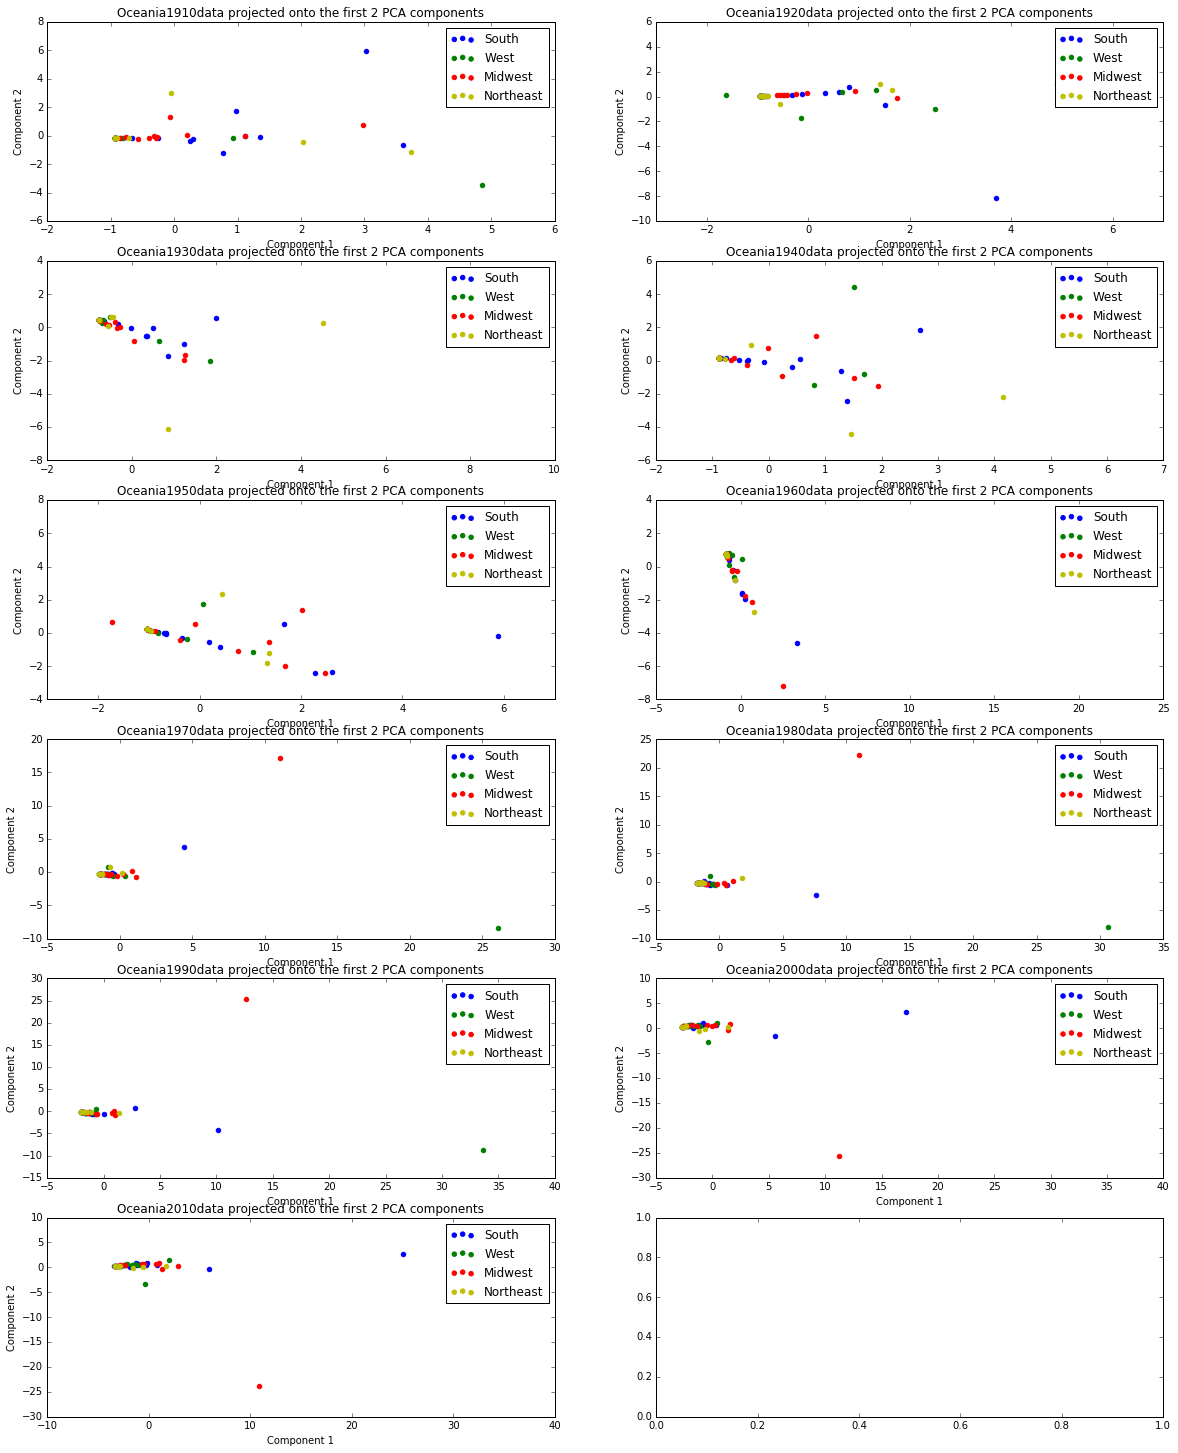

In [36]:
#plotting first two principal components for Oceania per decade
fig, ax = plt.subplots(6, 2, figsize = (20,25))
ax[0,0] = pca_per_decaderegion('Oceania',1910, ax[0,0])
ax[0,1] = pca_per_decaderegion('Oceania',1920, ax[0,1])
ax[1,0] = pca_per_decaderegion('Oceania',1930, ax[1,0])
ax[1,1] = pca_per_decaderegion('Oceania',1940, ax[1,1])
ax[2,0] = pca_per_decaderegion('Oceania',1950, ax[2,0])
ax[2,1] = pca_per_decaderegion('Oceania',1960, ax[2,1])
ax[3,0] = pca_per_decaderegion('Oceania',1970, ax[3,0])
ax[3,1] = pca_per_decaderegion('Oceania',1980, ax[3,1])
ax[4,0] = pca_per_decaderegion('Oceania',1990, ax[4,0])
ax[4,1] = pca_per_decaderegion('Oceania',2000, ax[4,1])
ax[5,0] = pca_per_decaderegion('Oceania',2010, ax[5,0])

#plt.tight_layout()
plt.show()

In [37]:
fig.savefig('pca_oceania.png', bbox_inches='tight')

### Americas

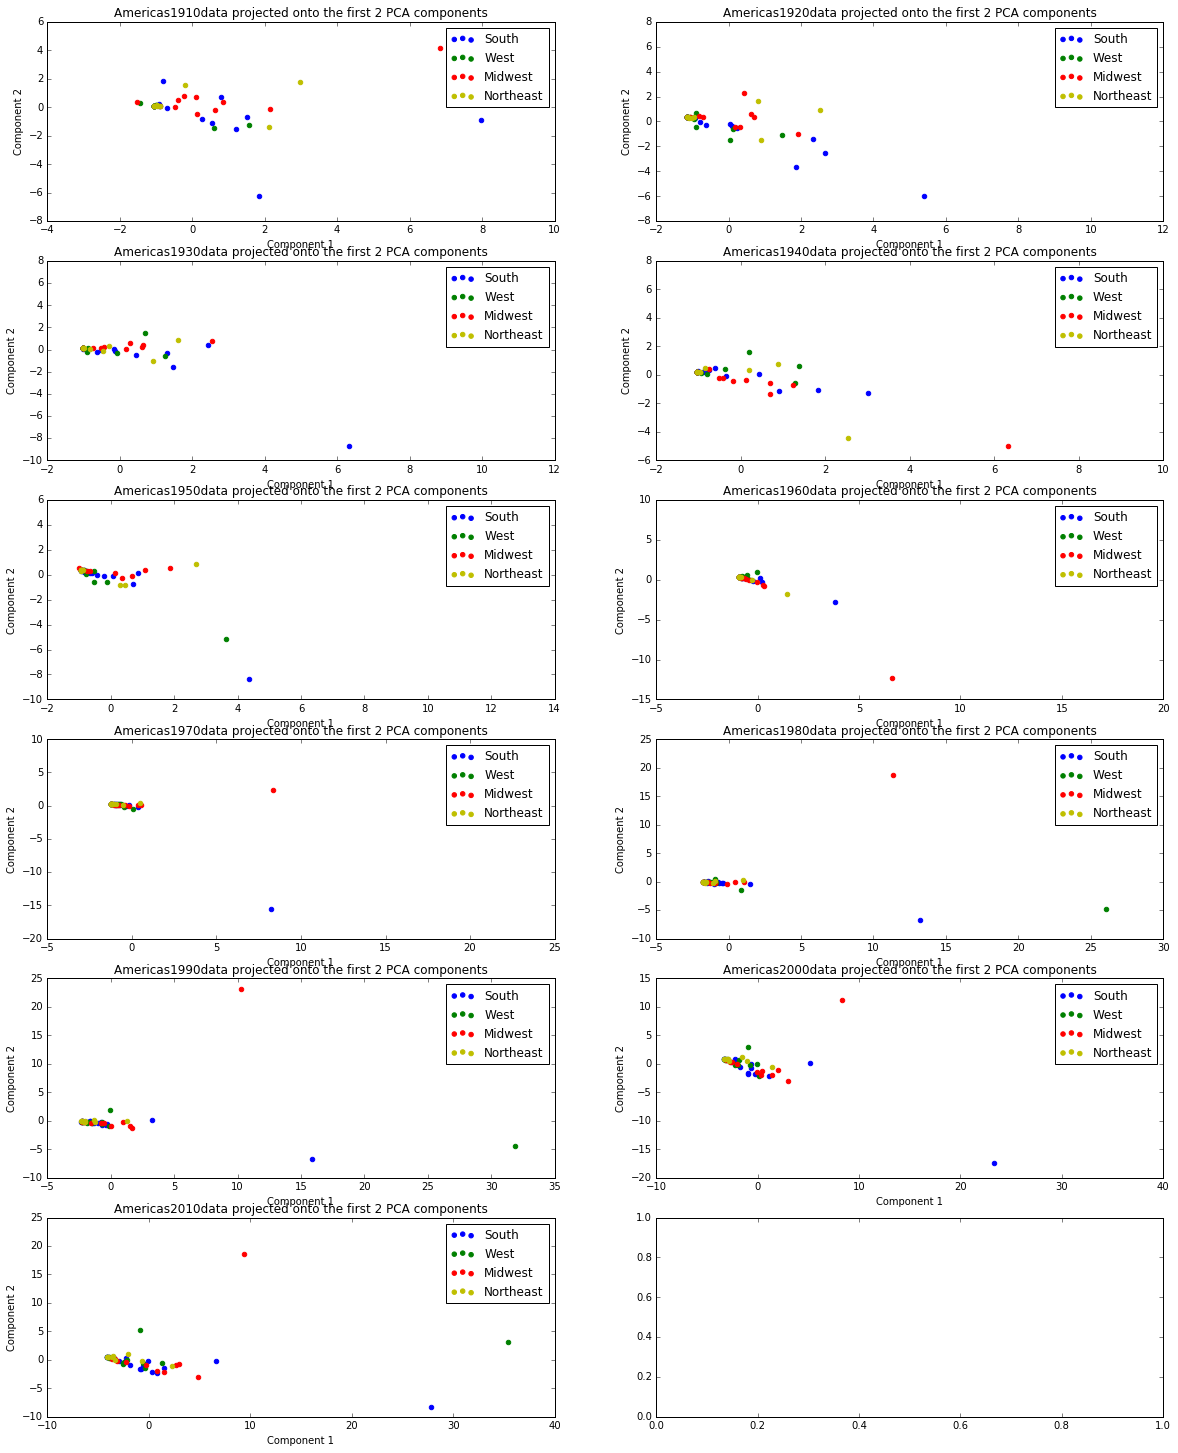

In [39]:
#plotting first two principal components for Americas per decade
fig, ax = plt.subplots(6, 2, figsize = (20,25))
ax[0,0] = pca_per_decaderegion('Americas',1910, ax[0,0])
ax[0,1] = pca_per_decaderegion('Americas',1920, ax[0,1])
ax[1,0] = pca_per_decaderegion('Americas',1930, ax[1,0])
ax[1,1] = pca_per_decaderegion('Americas',1940, ax[1,1])
ax[2,0] = pca_per_decaderegion('Americas',1950, ax[2,0])
ax[2,1] = pca_per_decaderegion('Americas',1960, ax[2,1])
ax[3,0] = pca_per_decaderegion('Americas',1970, ax[3,0])
ax[3,1] = pca_per_decaderegion('Americas',1980, ax[3,1])
ax[4,0] = pca_per_decaderegion('Americas',1990, ax[4,0])
ax[4,1] = pca_per_decaderegion('Americas',2000, ax[4,1])
ax[5,0] = pca_per_decaderegion('Americas',2010, ax[5,0])

#plt.tight_layout()
plt.show()

In [40]:
fig.savefig('pca_americas.png', bbox_inches='tight')

### Names with most variance in principal components

In [41]:
#function to print names that account for most variance in each principal component
def babyname_variance_explained(region, decade):
    x = cross_best_names(region, decade, byDecade=True)
    df_norm = (x-x.mean())/x.std()
    df_norm = df_norm.fillna(0)
    pca = PCA(n_components=2)
    pca.fit(df_norm.values)
    #Project to the data onto the two axes
    x_reduced = pca.transform(df_norm.values)
    
    identify = pd.DataFrame(pca.components_.T, columns=['PC-1', 'PC-2'], index=x.columns)

    identify_abs = identify.abs()
    
    print "Most represented names in", region , str(decade) + ':' , identify_abs['PC-1'].idxmax(),identify_abs['PC-2'].idxmax()
    identify_abs

### Most unique name by state

In [42]:
def unique_name_bystate(region, decade):
    x = cross_best_names(region, decade, byDecade=True)
    df_norm = (x-x.mean())/x.std()
    df_norm = df_norm.fillna(0)
    df_norm.head()

    return df_norm.idxmax(axis=1)

### Europe

In [43]:
eu_names_1910 = unique_name_bystate('Europe',1910)
eu_names_1920 = unique_name_bystate('Europe',1920)
eu_names_1930 = unique_name_bystate('Europe',1930)
eu_names_1940 = unique_name_bystate('Europe',1940)
eu_names_1950 = unique_name_bystate('Europe',1950)
eu_names_1960 = unique_name_bystate('Europe',1960)
eu_names_1970 = unique_name_bystate('Europe',1970)
eu_names_1980 = unique_name_bystate('Europe',1980)
eu_names_1990 = unique_name_bystate('Europe',1990)
eu_names_2000 = unique_name_bystate('Europe',2000)
eu_names_2010 = unique_name_bystate('Europe',2010)

In [44]:
states_list_eu = list(eu_names_1910.index.values)

In [48]:
decades = [1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010]

In [49]:
#make into a dataframe
d1 = {1910 : pd.Series(eu_names_1910.values, index = states_list_eu),
    1920 : pd.Series(eu_names_1920.values, index = states_list_eu),
    1930 : pd.Series(eu_names_1930.values, index = states_list_eu),
    1940 : pd.Series(eu_names_1940.values, index = states_list_eu),
    1950 : pd.Series(eu_names_1950.values, index = states_list_eu),
    1960 : pd.Series(eu_names_1960.values, index = states_list_eu),
    1970 : pd.Series(eu_names_1970.values, index = states_list_eu),
    1980 : pd.Series(eu_names_1980.values, index = states_list_eu),
    1990 : pd.Series(eu_names_1990.values, index = states_list_eu),
    2000 : pd.Series(eu_names_2000.values, index = states_list_eu),
    2010 : pd.Series(eu_names_2010.values, index = states_list_eu),}

In [50]:
df1 = pd.DataFrame(d1, index=states_list_eu, columns=decades)

In [51]:
df1.to_csv('Datasets/unique_names_bystate_eu.csv')

### Africa

In [67]:
af_names_1910 = unique_name_bystate('Africa',1910)
af_names_1920 = unique_name_bystate('Africa',1920)
af_names_1930 = unique_name_bystate('Africa',1930)
af_names_1940 = unique_name_bystate('Africa',1940)
af_names_1950 = unique_name_bystate('Africa',1950)
af_names_1960 = unique_name_bystate('Africa',1960)
af_names_1970 = unique_name_bystate('Africa',1970)
af_names_1980 = unique_name_bystate('Africa',1980)
af_names_1990 = unique_name_bystate('Africa',1990)
af_names_2000 = unique_name_bystate('Africa',2000)
af_names_2010 = unique_name_bystate('Africa',2010)

In [68]:
states_list_af = list(af_names_1910.index.values)

In [69]:
#make into a dataframe
d2 = {1910 : pd.Series(af_names_1910.values, index = states_list_af),
    1920 : pd.Series(af_names_1920.values, index = states_list_af),
    1930 : pd.Series(af_names_1930.values, index = states_list_af),
    1940 : pd.Series(af_names_1940.values, index = states_list_af),
    1950 : pd.Series(af_names_1950.values, index = states_list_af),
    1960 : pd.Series(af_names_1960.values, index = states_list_af),
    1970 : pd.Series(af_names_1970.values, index = states_list_af),
    1980 : pd.Series(af_names_1980.values, index = states_list_af),
    1990 : pd.Series(af_names_1990.values, index = states_list_af),
    2000 : pd.Series(af_names_2000.values, index = states_list_af),
    2010 : pd.Series(af_names_2010.values, index = states_list_af),}

In [70]:
df2 = pd.DataFrame(d2, index=states_list_af, columns=decades)

In [71]:
df2.to_csv('Datasets/unique_names_bystate_af.csv')

### Asia

In [52]:
as_names_1910 = unique_name_bystate('Asia',1910)
as_names_1920 = unique_name_bystate('Asia',1920)
as_names_1930 = unique_name_bystate('Asia',1930)
as_names_1940 = unique_name_bystate('Asia',1940)
as_names_1950 = unique_name_bystate('Asia',1950)
as_names_1960 = unique_name_bystate('Asia',1960)
as_names_1970 = unique_name_bystate('Asia',1970)
as_names_1980 = unique_name_bystate('Asia',1980)
as_names_1990 = unique_name_bystate('Asia',1990)
as_names_2000 = unique_name_bystate('Asia',2000)
as_names_2010 = unique_name_bystate('Asia',2010)

In [53]:
states_list_as = list(as_names_1910.index.values)

In [54]:
#make into a dataframe
d3 = {1910 : pd.Series(as_names_1910.values, index = states_list_as),
    1920 : pd.Series(as_names_1920.values, index = states_list_as),
    1930 : pd.Series(as_names_1930.values, index = states_list_as),
    1940 : pd.Series(as_names_1940.values, index = states_list_as),
    1950 : pd.Series(as_names_1950.values, index = states_list_as),
    1960 : pd.Series(as_names_1960.values, index = states_list_as),
    1970 : pd.Series(as_names_1970.values, index = states_list_as),
    1980 : pd.Series(as_names_1980.values, index = states_list_as),
    1990 : pd.Series(as_names_1990.values, index = states_list_as),
    2000 : pd.Series(as_names_2000.values, index = states_list_as),
    2010 : pd.Series(as_names_2010.values, index = states_list_as),}

In [55]:
df3 = pd.DataFrame(d3, index=states_list_as, columns=decades)

In [56]:
df3.to_csv('Datasets/unique_names_bystate_as.csv')

### Oceania

In [57]:
oc_names_1910 = unique_name_bystate('Oceania',1910)
oc_names_1920 = unique_name_bystate('Oceania',1920)
oc_names_1930 = unique_name_bystate('Oceania',1930)
oc_names_1940 = unique_name_bystate('Oceania',1940)
oc_names_1950 = unique_name_bystate('Oceania',1950)
oc_names_1960 = unique_name_bystate('Oceania',1960)
oc_names_1970 = unique_name_bystate('Oceania',1970)
oc_names_1980 = unique_name_bystate('Oceania',1980)
oc_names_1990 = unique_name_bystate('Oceania',1990)
oc_names_2000 = unique_name_bystate('Oceania',2000)
oc_names_2010 = unique_name_bystate('Oceania',2010)

In [58]:
states_list_oc = list(oc_names_1910.index.values)

In [59]:
#make into a dataframe
d4 = {1910 : pd.Series(oc_names_1910.values, index = states_list_oc),
    1920 : pd.Series(oc_names_1920.values, index = states_list_oc),
    1930 : pd.Series(oc_names_1930.values, index = states_list_oc),
    1940 : pd.Series(oc_names_1940.values, index = states_list_oc),
    1950 : pd.Series(oc_names_1950.values, index = states_list_oc),
    1960 : pd.Series(oc_names_1960.values, index = states_list_oc),
    1970 : pd.Series(oc_names_1970.values, index = states_list_oc),
    1980 : pd.Series(oc_names_1980.values, index = states_list_oc),
    1990 : pd.Series(oc_names_1990.values, index = states_list_oc),
    2000 : pd.Series(oc_names_2000.values, index = states_list_oc),
    2010 : pd.Series(oc_names_2010.values, index = states_list_oc),}

In [60]:
df4 = pd.DataFrame(d4, index=states_list_oc, columns=decades)

In [61]:
df4.to_csv('Datasets/unique_names_bystate_oc.csv')

### Americas

In [62]:
am_names_1910 = unique_name_bystate('Americas',1910)
am_names_1920 = unique_name_bystate('Americas',1920)
am_names_1930 = unique_name_bystate('Americas',1930)
am_names_1940 = unique_name_bystate('Americas',1940)
am_names_1950 = unique_name_bystate('Americas',1950)
am_names_1960 = unique_name_bystate('Americas',1960)
am_names_1970 = unique_name_bystate('Americas',1970)
am_names_1980 = unique_name_bystate('Americas',1980)
am_names_1990 = unique_name_bystate('Americas',1990)
am_names_2000 = unique_name_bystate('Americas',2000)
am_names_2010 = unique_name_bystate('Americas',2010)

In [63]:
states_list_am = list(am_names_1910.index.values)

In [64]:
#make into a dataframe
d5 = {1910 : pd.Series(am_names_1910.values, index = states_list_am),
    1920 : pd.Series(am_names_1920.values, index = states_list_am),
    1930 : pd.Series(am_names_1930.values, index = states_list_am),
    1940 : pd.Series(am_names_1940.values, index = states_list_am),
    1950 : pd.Series(am_names_1950.values, index = states_list_am),
    1960 : pd.Series(am_names_1960.values, index = states_list_am),
    1970 : pd.Series(am_names_1970.values, index = states_list_am),
    1980 : pd.Series(am_names_1980.values, index = states_list_am),
    1990 : pd.Series(am_names_1990.values, index = states_list_am),
    2000 : pd.Series(am_names_2000.values, index = states_list_am),
    2010 : pd.Series(am_names_2010.values, index = states_list_am),}

In [65]:
df5 = pd.DataFrame(d5, index=states_list_am, columns=decades)

In [66]:
df5.to_csv('Datasets/unique_names_bystate_am.csv')

### K-means Clustering

In [72]:
region = 'Europe'
decade = 1920
x = cross_best_names(region, decade, byDecade=True)
df_norm = (x-x.mean())/x.std()
df_norm = df_norm.fillna(0)
pca = PCA(n_components=2)
pca.fit(df_norm.values)
x_reduced = pca.transform(df_norm.values)
region_x = pd.DataFrame(x_reduced, columns=['PC-1', 'PC-2'])
us_region = region_x.join(regions)
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans = kmeans.fit(us_region.iloc[:,[0,1]])
# make a copy, just so we don't mess with the previous for testing
classes = us_region.copy()
classes['guess'] = pd.Series(kmeans.labels_, index=us_region.index)
display(classes)

,PC-1,PC-2,2,guess
0,-3.918117,-1.677570,South,2
1,12.497786,-6.464108,West,0
2,2.939279,-0.386304,West,1
3,-3.531181,-1.467305,South,2
4,-0.935832,1.627862,West,1
5,-3.040422,-0.922168,West,2
6,-3.643871,-1.086604,Northeast,2
7,-3.770574,-1.548212,South,2
8,-3.886193,-1.633733,South,2
9,-0.888154,-1.584775,South,2
